In [1]:
# Setup the library
import pyrogue as pr
import os, sys
import matplotlib.pyplot as plt
import time
import numpy as np
import math

from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats import norm


top_level=f'{os.getcwd()}/../../../'
pr.addLibraryPath( f'{top_level}/scripts' )
import setupLibPaths
import epix_hr_single_10k
import ePixViewer.Cameras as cameras

%run ../../ASIC_V4/supportFunctions.ipynb

In [2]:
# Create and start the root class
root = epix_hr_single_10k.RootLCLSIITiming(
    top_level   = top_level,
    sim         = False,
    dev         = '/dev/datadev_0',
    asicVersion = 4
)
root.start()

Simulation mode : False
Start: Started zmqServer on ports 9099-9101
    To start a gui: python -m pyrogue gui --server='localhost:9099'
    To use a virtual client: client = pyrogue.interfaces.VirtualClient(addr='localhost', port=9099)


In [3]:
# Create useful pointers
AxiVersion = root.Core.AxiVersion
print ( '###################################################')
print ( '#             Firmware Version                    #')
print ( '###################################################')
AxiVersion.printStatus()
print ( '###################################################')

###################################################
#             Firmware Version                    #
###################################################
Path         = ePixHr10kT.Core.AxiVersion
FwVersion    = 0x3010000
UpTime       = 3 days, 3:04:23
GitHash      = 0x563a68027652195474e6a610098a11775111615a
XilinxDnaId  = 0x4002000101604ee71c61a3c5
FwTarget     = EpixHr10kTLclsIITiming
BuildEnv     = Vivado v2022.2
BuildServer  = rdsrv408 (Ubuntu 20.04.6 LTS)
BuildDate    = Thu 02 Nov 2023 02:16:58 PM PDT
Builder      = ddoering
###################################################


# Helper functions

In [98]:
# Define the linear function
def linear_function(x, a, b):
    return a * x + b

def getResidualsLinFit(x,y):
    
    weights = np.exp(-(x - np.mean(x))**2 / (2 * np.std(x)**2))
    params, covariance = curve_fit(linear_function, x, y, sigma=1/weights, absolute_sigma=True)
    y_fit = linear_function(x, *params)
   
    return (y - y_fit)

def getGainLinFit(x,y):
    
    weights = np.exp(-(x - np.mean(x))**2 / (2 * np.std(x)**2))
    params, covariance = curve_fit(linear_function, x, y, sigma=1/weights, absolute_sigma=True)
    y_fit = linear_function(x, *params)
   
    return params[0]

# returns (gain, offset)
def getLinFit(x,y):
    
    weights = np.exp(-(x - np.mean(x))**2 / (2 * np.std(x)**2))
    params, covariance = curve_fit(linear_function, x, y, sigma=1/weights, absolute_sigma=True)
    y_fit = linear_function(x, *params)
   
    return params[0], params[1]

import matplotlib.cm

def progCMap(numPoints=10):
    colors = matplotlib.cm.copper(np.linspace(0, 1, numPoints))
    return colors

# Initialization

In [5]:
MAX_NUMBER_OF_FRAMES_PER_BATCH  = 1000
cameraType            = 'ePixHr10kTBatcher'
bitMask               = 0xffff
currentCam = cameras.Camera(cameraType = cameraType)
currentCam.bitMask = bitMask

Camera  ePixHr10kTBatcher  selected.


In [6]:
#Initialze the camera
#[routine, asic0, asic1, asic2, asic3]'
initSequence = 5
root.EpixHR.InitASIC([initSequence,0,0,1,0])
#points to the ASIC device under test
ASIC = root.EpixHR.Hr10kTAsic2
root.EpixHR.BatcherEventBuilder0.Blowoff.set(True)
root.EpixHR.BatcherEventBuilder0.Bypass.set(1)
root.EpixHR.BatcherEventBuilder1.Blowoff.set(False)
root.EpixHR.BatcherEventBuilder1.Bypass.set(1)
root.EpixHR.BatcherEventBuilder2.Blowoff.set(True)

Rysync ASIC started
Init ASIC script started
Loading MMCM configuration
/u3/ePix10k/epix-hr-single-10k/software/notebooks/Lorenzo/Pixel/../../..//yml/ePixHr10kT_MMCM_320MHz.yml
Completed
Loading supply configuration
/u3/ePix10k/epix-hr-single-10k/software/notebooks/Lorenzo/Pixel/../../..//yml/ePixHr10kT_PowerSupply_Enable.yml
Loading register control (waveforms) configuration
/u3/ePix10k/epix-hr-single-10k/software/notebooks/Lorenzo/Pixel/../../..//yml/ePixHr10kT_RegisterControl_R0Width12us_AcqWidth24us_320MHz.yml
Loading packet registers
Disabling packet lanes for ASIC 0
Disabling packet lanes for ASIC 1
Disabling packet lanes for ASIC 3
/u3/ePix10k/epix-hr-single-10k/software/notebooks/Lorenzo/Pixel/../../..//yml/ePixHr10kT_PacketRegisters.yml
Taking asic off of reset
Loading ASIC and timing configuration
Loading  /u3/ePix10k/epix-hr-single-10k/software/notebooks/Lorenzo/Pixel/../../..//yml/ePixHr10kT_PLLBypass_248MHz_ASIC_2.yml
Command executed :  <class 'pyrogue._Command.BaseComman

In [7]:
#Makes sure triggers are off
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.1)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
time.sleep(10)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.1)

#use system with batcher and missing ASICs
root.EpixHR.SspLowSpeedDecoderReg.enable.set(True)
print ("Locked lanes: %x" % root.EpixHR.SspLowSpeedDecoderReg.Locked.get())
#Only ASIC 1 is available so disable the 6 lower lanes
root.EpixHR.PacketRegisters0.DisableLane.set(0x3FF)
root.EpixHR.PacketRegisters1.DisableLane.set(0xFC0)

Locked lanes: 3f000


# Set pixel configuration

In [17]:
# pixelList = [[10, 10, 1],[10, 42, 5],[42, 10, 9],[42, 42, 13]]
# pixelOffset = 0
# pixelListRB = [[20, 30+pixelOffset, 1],[20, 35+pixelOffset, 5],[20, 40+pixelOffset, 9],[20, 45+pixelOffset, 13]]
# for i in range(len(pixelList)):
#     print(f'\nPixel [%d, %d]' %(pixelList[i][0], pixelList[i][1]))
#     print (f'Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): %d' % readPixelConfig(ASIC, pixelList[i][0], pixelList[i][1]))
#     print (f'Writing individula pixel')
#     writedPixelConfig(ASIC, pixelList[i][0], pixelList[i][1], pixelList[i][2])
#     print (f'Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): %d' % readPixelConfig(ASIC, pixelList[i][0], pixelList[i][1]))

for row in range(144):    
    for col in range(192):    
        writedPixelConfig(ASIC, row, col, 1)
    
# asic.clearmatrix(1)    

In [100]:
#Makes sure triggers are off
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.2)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
time.sleep(0.2)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.2)

# ------------------------------------ ADC
# Disable external DAC
ASIC.mTest.set(False)

# ADC settings
ASIC.RefGenB.set(1) #2 bits
ASIC.RefGenC.set(2) #2 bits
ASIC.S2D_1_b.set(0) #3 bits
ASIC.shvc_DAC.set(30) #6 bits
ASIC.S2dDacBias.set(3)
ASIC.DHg.set(False)

# ------------------------------------ Pixel
# Set references 
Preamp     = 3 #4
Vld1_b     = 1 #1
Pixel_CB   = 4 #4
Filter_DAC = 20 #38
VRef_DAC   = 40 #53
CompTH_DAC = 28

# Write data
setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)
ASIC.CompTH_DAC.set(CompTH_DAC)

ASIC.CompEn.set(2)
ASIC.CompEnOn.set(True) 

# Set High Gain ----------------------------------------------------------
cfgHG = True

if cfgHG==True:
    gainCfg = 'HG'
else:
    gainCfg = 'MG'

ASIC.trbit.set(cfgHG) # high/medium gain
print (f'Check trbit (0: medium gain, 1: high gain): %d' % ASIC.trbit.get())

# ------------------------------------ Pulser for Charge injection
ASIC.PulserR.set(True)
ASIC.PulserR.set(False)
ASIC.MonostPulser.set(7)

# Enable Pulser Ch. Injection
ASIC.test.set(True)
ASIC.atest.set(True)

######################################################################################################################
# Remove previous dataset
filename = (f'/u1/lorenzor/10kthr_data/temp.dat')

Preamp 3
Vld1_b 1
Pixel_CB 4
Filter_DAC 20
VRef_DAC 40
Check trbit (0: medium gain, 1: high gain): 1


# Matrix scan


In [106]:
SNR       = np.zeros([144,192]) # SNR (in high-gain)
noise_adu = np.zeros([144,192]) # Noise (from dark)
gainHGarr = np.zeros([144,192]) # Gain in high-gain region 
gainLGarr = np.zeros([144,192]) # Gain in low-gain region

pedHG     = np.zeros([144,192]) # Pedestal in HG
satHG     = np.zeros([144,192]) # Saturation in HG
pedLG     = np.zeros([144,192]) # Pedestal in LG region


#  Plotting options
# colors = progCMap(len(scanValues))

# fig=plt.figure(figsize=(10,10))
# ax1 = plt.subplot(211)
# ax2 = plt.subplot(212, sharex = ax1)


for i in range(1):
   
    # Configure Pulser Ch. Injection
    ASIC.test.set(False)
    ASIC.atest.set(False)

    # Full-matrix, CommMode corrected noise
    dataOpt = run_asic_test(numFrames = 2000, initialDelay = 0)[:1000,:,0:192];
    data = np.bitwise_and(dataOpt, 0x3FFF)
    dark   = np.mean(data, axis=0)
    dataCM = data - np.mean(data, axis=(0), keepdims=True)
    dataCM -= np.mean(dataCM, axis=(1,2), keepdims=True)
    dataCM -= np.mean(dataCM, axis=(1), keepdims=True)
    dataCM -= np.mean(dataCM, axis=(2), keepdims=True)
    noise_adu = np.std(dataCM, axis=0)

    #-------
    # Always reset the pulser, so we run from same start/stop
    ASIC.PulserR.set(True)
    ASIC.PulserR.set(False)
    ASIC.test.set(True)
    ASIC.atest.set(True)
    # Create arbitrary array to do the fitting against
    pulserValues = np.arange(np.shape(data)[0])

    # Fit and calculate gain
    dataOpt = run_asic_test(numFrames = 2000, initialDelay = 0)[:1000,0:144,0:192];
    
    # Bit operations
    gainbit = np.bitwise_and(dataOpt.astype(int), 0x8000) >> 15
    data    = np.bitwise_and(dataOpt, 0x3FFF)
    
    for row in range(144):
        print ("\r"+'Processing row',row,'/144',end="")
        for col in range(192):
            # Create masks for HG (or MG) and LG
            HG = gainbit[:,row,col]==0
            LG = gainbit[:,row,col]==1
            # Fit the two gains
            try:
                gain_HG = getGainLinFit(pulserValues[HG], data[HG,row,col])
            except:
                gain_HG = 0
            try:
                gain_LG, pedLG[row,col] = getLinFit(pulserValues[LG], data[LG,row,col])
            except:
                # print('No Gain switching found')
                gain_LG = 0
                pedLG[row,col] = 0
                
            # # Get residuals
            # try:
            #     resHG = getResidualsLinFit(pulserValues[HG], data[HG,row,col])
            # except:
            #     resHG = 0
            # try:
            #     resLG = getResidualsLinFit(pulserValues[LG], data[LG,row,col])
            # except:
            #     # print('No Gain switching found')
            #     resLG = 0
            
            # Saturation point in HG
            satHG[row,col] = max(data[HG,row,col])
            
            # # Pedestal LG
            # try:
            #     pedLG[row,col] = min(data[LG,row,col])
            # except:
            #     pedLG[row,col] = 0
                
            gainHGarr[row,col] = gain_HG
            gainLGarr[row,col] = gain_LG
            SNR[row,col] = gain_HG/noise_adu[row,col]
   

/u1/lorenzor/10kthr_data/temp.dat
Aquisition Counter 1476654
DAQ Counter 1451524
Number of frames received: 0
Delta Aquisition Counter: 2001
Number of frames received: 2001
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56072)
/u1/lorenzor/10kthr_data/temp.dat
Aquisition Counter 1478655
DAQ Counter 1453525
Number of frames received: 0
Delta Aquisition Counter: 2001
Number of frames received: 2001
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56072)
Processing row 143 /144

# Plots

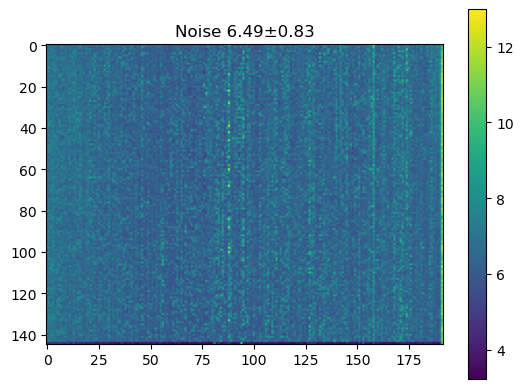

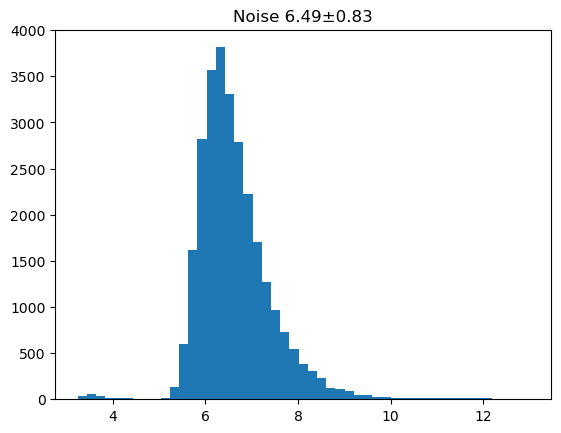

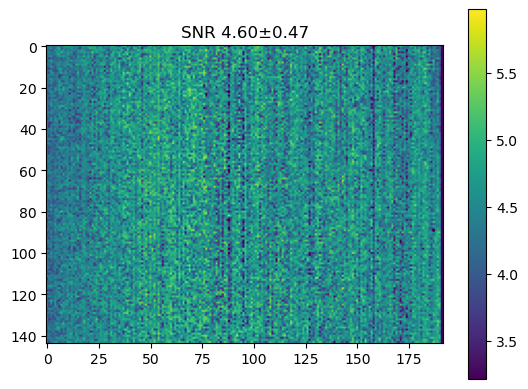

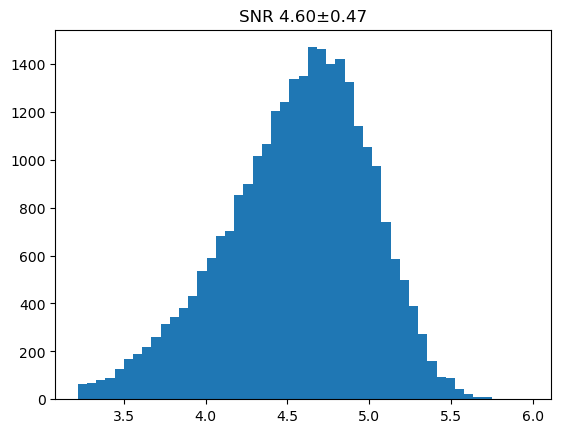

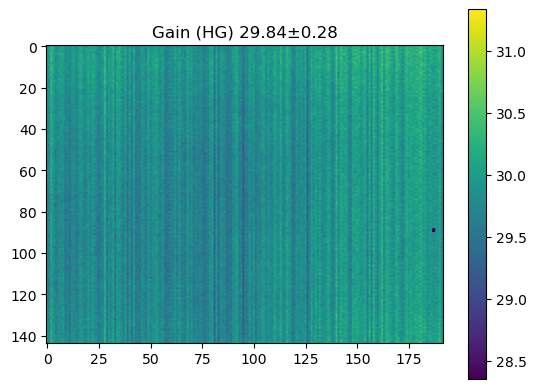

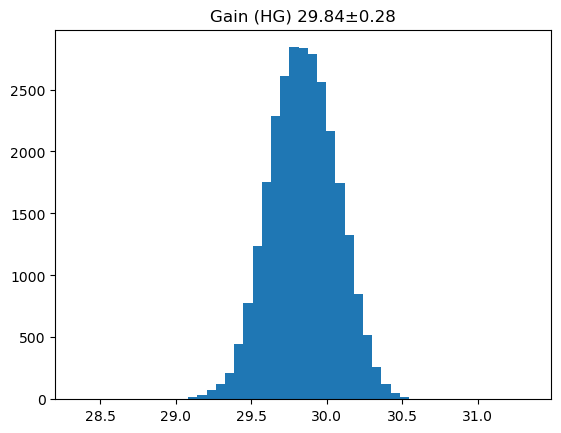

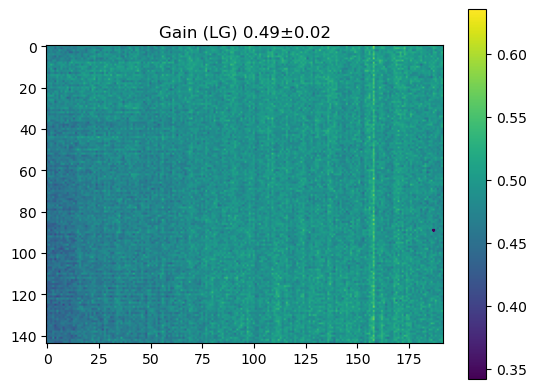

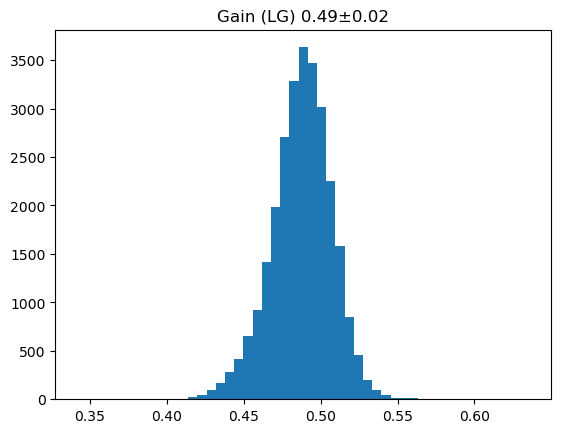

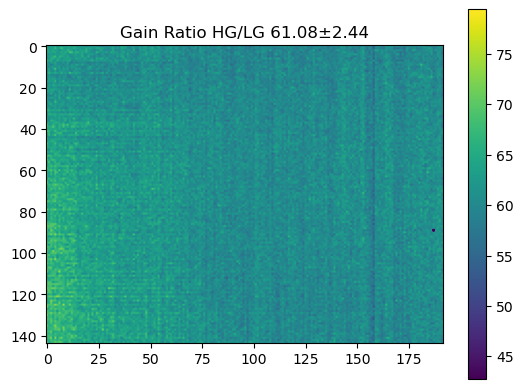

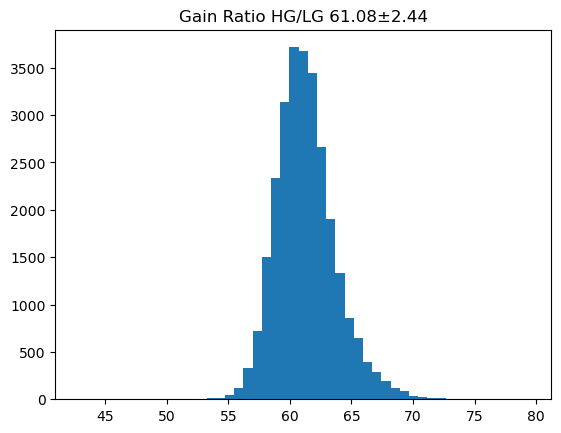

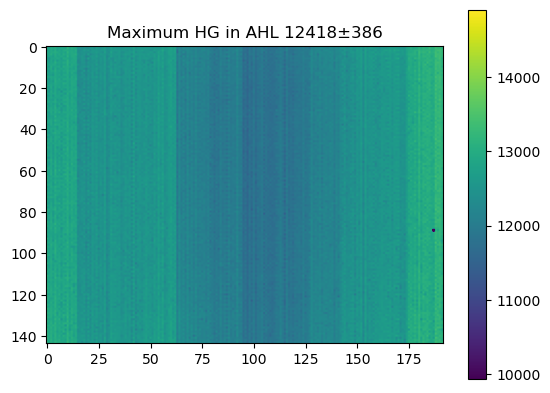

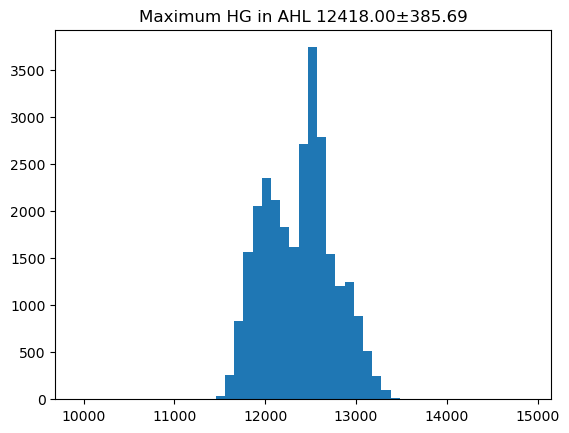

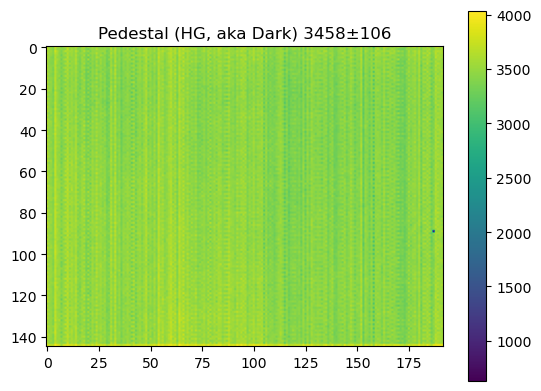

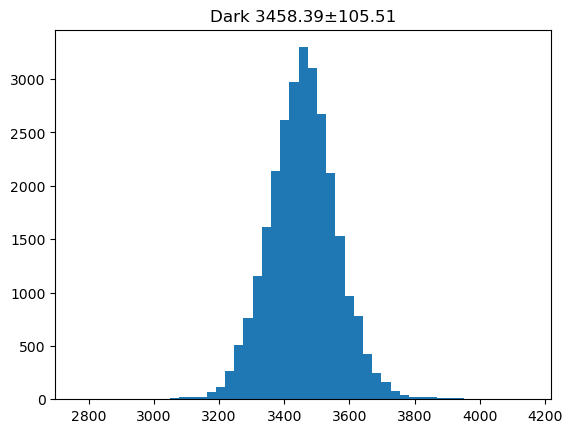

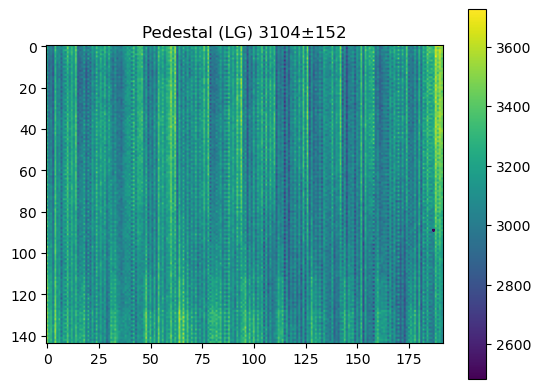

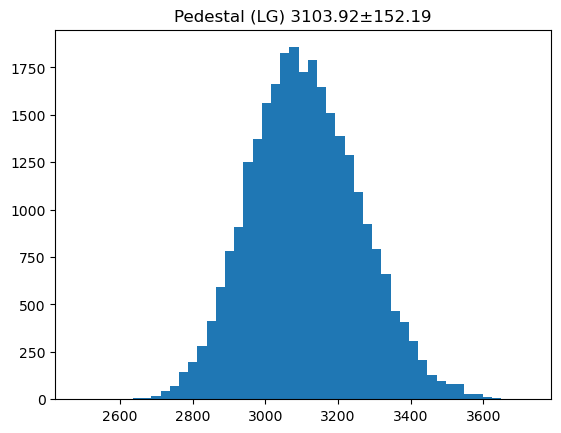

In [108]:
# Signal to noise ration
value = noise_adu
value_mean = np.median(value)
value_max  = value_mean * 2
value_min  = value_mean * 0.5
value_std  = np.std(value)

plt.imshow(value, vmin=value_min, vmax=value_max)
plt.colorbar()
plt.title('Noise {:.2f}±{:.2f}'.format(value_mean, value_std))
plt.show()

bins = np.linspace(value_min, value_max, 50);
plt.hist(value.flatten(),bins=bins)
plt.title('Noise {:.2f}±{:.2f}'.format(value_mean, value_std))
plt.show()


# Signal to noise ration
value = SNR
value_mean = np.median(value)
value_max  = value_mean * 1.3
value_min  = value_mean * 0.7
value_std  = np.std(value)

plt.imshow(value, vmin=value_min, vmax=value_max)
plt.colorbar()
plt.title('SNR {:.2f}±{:.2f}'.format(value_mean, value_std))
plt.show()

bins = np.linspace(value_min, value_max, 50);
plt.hist(value.flatten(),bins=bins)
plt.title('SNR {:.2f}±{:.2f}'.format(value_mean, value_std))
plt.show()


# Gain HG
value = gainHGarr
value_mean = np.median(value)
value_max  = value_mean * 1.05
value_min  = value_mean * 0.95
value_std  = np.std(value)

plt.imshow(value, vmin=value_min, vmax=value_max)
plt.colorbar()
plt.title('Gain (HG) {:.2f}±{:.2f}'.format(value_mean, value_std))
plt.show()

bins = np.linspace(value_min, value_max, 50);
plt.hist(value.flatten(),bins=bins)
plt.title('Gain (HG) {:.2f}±{:.2f}'.format(value_mean, value_std))
plt.show()


# Gain LG
value = gainLGarr
value_mean = np.median(value)
value_max  = value_mean * 1.3
value_min  = value_mean * 0.7
value_std  = np.std(value)

plt.imshow(value, vmin=value_min, vmax=value_max)
plt.colorbar()
plt.title('Gain (LG) {:.2f}±{:.2f}'.format(value_mean, value_std))
plt.show()

bins = np.linspace(value_min, value_max, 50);
plt.hist(value.flatten(),bins=bins)
plt.title('Gain (LG) {:.2f}±{:.2f}'.format(value_mean, value_std))
plt.show()



# Gain Ratio HG/LG
value = gainHGarr/gainLGarr
value_mean = np.median(value)
value_max  = value_mean * 1.3
value_min  = value_mean * 0.7
value_std  = np.std(value)

plt.imshow(value, vmin=value_min, vmax=value_max)
plt.colorbar()
plt.title('Gain Ratio HG/LG {:.2f}±{:.2f}'.format(value_mean, value_std))
plt.show()

bins = np.linspace(value_min, value_max, 50);
plt.hist(value.flatten(),bins=bins)
plt.title('Gain Ratio HG/LG {:.2f}±{:.2f}'.format(value_mean, value_std))
plt.show()

# Maximum HG point
value = satHG
value_mean = np.median(value)
value_max  = value_mean * 1.2
value_min  = value_mean * 0.8
value_std  = np.std(value)

plt.imshow(value, vmin=value_min, vmax=value_max)
plt.colorbar()
plt.title('Maximum HG in AHL {:.0f}±{:.0f}'.format(value_mean, value_std))
plt.show()

bins = np.linspace(value_min, value_max, 50);
plt.hist(value.flatten(),bins=bins)
plt.title('Maximum HG in AHL {:.2f}±{:.2f}'.format(value_mean, value_std))
plt.show()


# Pedestal High-gain (Dark)
value = dark
value_mean = np.median(value)
value_max  = value_mean * 1.2
value_min  = value_mean * 0.8
value_std  = np.std(value)

plt.imshow(value)
plt.colorbar()
plt.title('Pedestal (HG, aka Dark) {:.0f}±{:.0f}'.format(value_mean, value_std))
plt.show()

bins = np.linspace(value_min, value_max, 50);
plt.hist(value.flatten(),bins=bins)
plt.title('Dark {:.2f}±{:.2f}'.format(value_mean, value_std))
plt.show()


# Pedestal low-gain
value = pedLG
value_mean = np.median(value)
value_max  = value_mean * 1.2
value_min  = value_mean * 0.8
value_std  = np.std(value)

plt.imshow(value, vmin=value_min, vmax=value_max)
plt.colorbar()
plt.title('Pedestal (LG) {:.0f}±{:.0f}'.format(value_mean, value_std))
plt.show()

bins = np.linspace(value_min, value_max, 50);
plt.hist(value.flatten(),bins=bins)
plt.title('Pedestal (LG) {:.2f}±{:.2f}'.format(value_mean, value_std))
plt.show()


Text(0.5, 1.0, 'Tiger teeth - Image after gain-switching minus pedestal in LG')

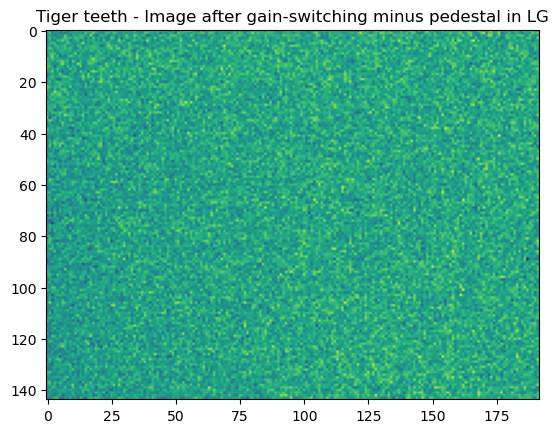

In [109]:
plt.imshow(data[600,0:144,:]-pedLG)
plt.title('Tiger teeth - Image after gain-switching minus pedestal in LG')

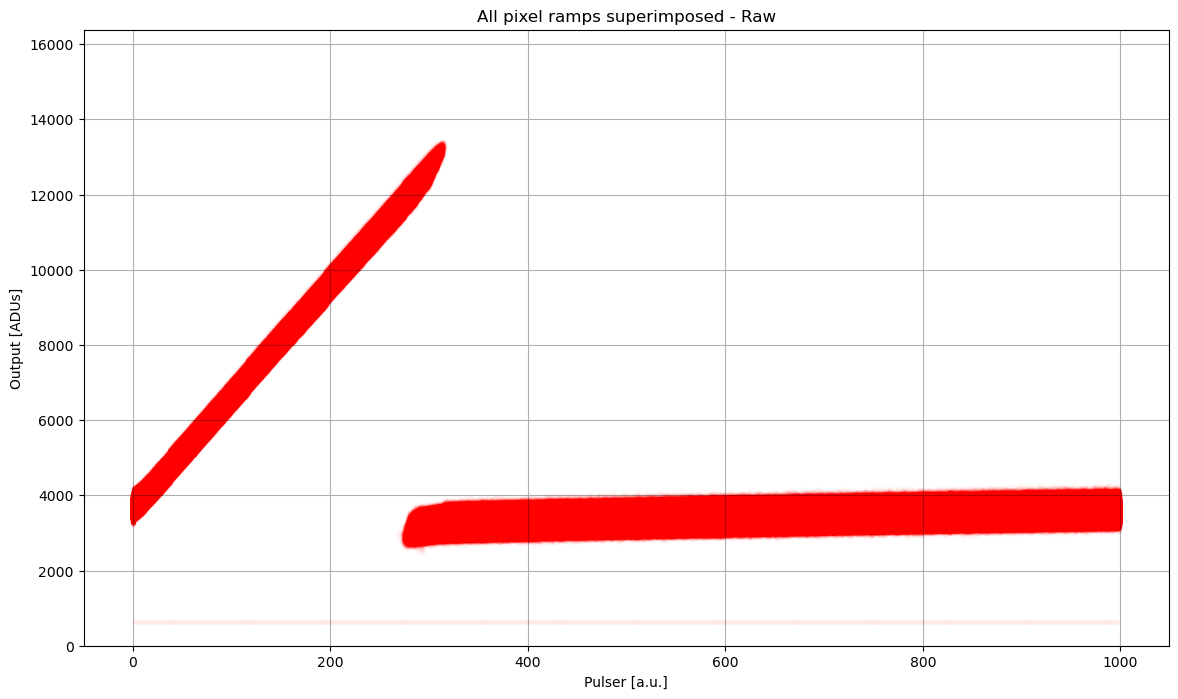

In [103]:
fig=plt.figure(figsize=(14,8))

for row in range(144):
    for col in range(192):
        plt.plot(data[:,row,col], '.', alpha=0.01, color='red')

plt.xlabel('Pulser [a.u.]')
plt.ylabel('Output [ADUs]')
plt.ylim([0,2**14])
plt.title('All pixel ramps superimposed - Raw')
plt.grid()

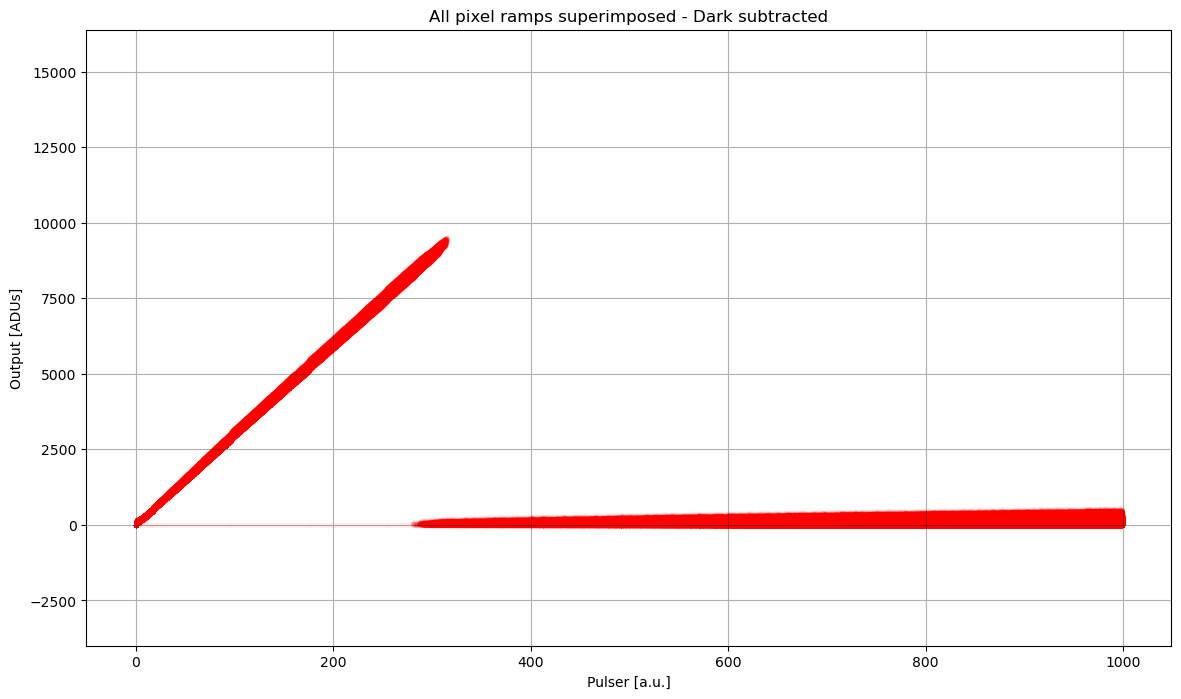

In [104]:
fig=plt.figure(figsize=(14,8))

for row in range(144):
    for col in range(192):
        plt.plot(data[:,row,col]-data[0,row,col], '.', alpha=0.01, color='red')

plt.xlabel('Pulser [a.u.]')
plt.ylabel('Output [ADUs]')
plt.ylim([-4000,2**14])
plt.title('All pixel ramps superimposed - Dark subtracted')
plt.grid()

# Check matrix-level

/u1/lorenzor/10kthr_data/temp.dat
Aquisition Counter 1465445
DAQ Counter 1440315
Number of frames received: 1
Delta Aquisition Counter: 2004
Number of frames received: 2004
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56072)


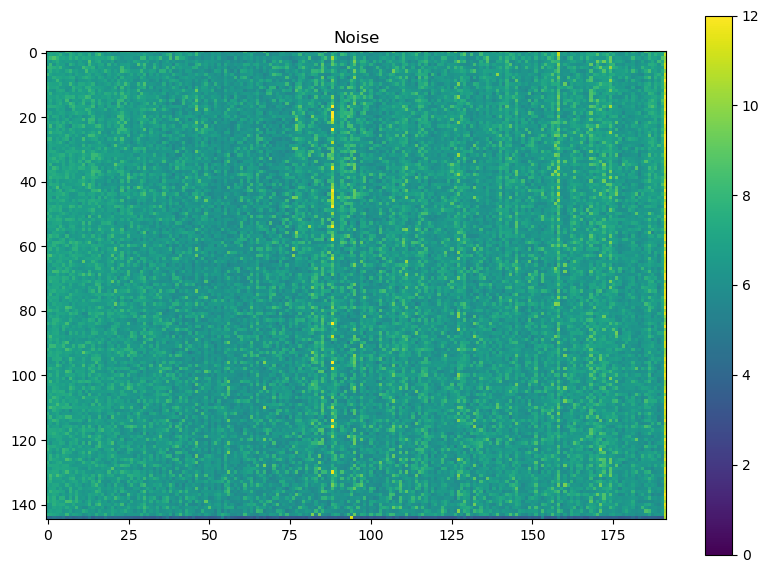

In [63]:
# Always reset the pulser, so we run from same start/stop
ASIC.PulserR.set(True)
ASIC.PulserR.set(False)
ASIC.test.set(False)
ASIC.atest.set(False)

dataOpt = run_asic_test(numFrames = 2000, initialDelay = 0)[:1000,:,0:192];

data = np.bitwise_and(dataOpt, 0x3FFF)
dataCM = data - np.mean(data, axis=(0), keepdims=True)
dataCM -= np.mean(dataCM, axis=(1,2), keepdims=True)
dataCM -= np.mean(dataCM, axis=(1), keepdims=True)
dataCM -= np.mean(dataCM, axis=(2), keepdims=True)
noise = np.std(dataCM, axis=0)

plt.figure(figsize = (10,7))
plt.imshow(noise, vmin=0, vmax=12)
plt.colorbar()
plt.title('Noise')
plt.show()


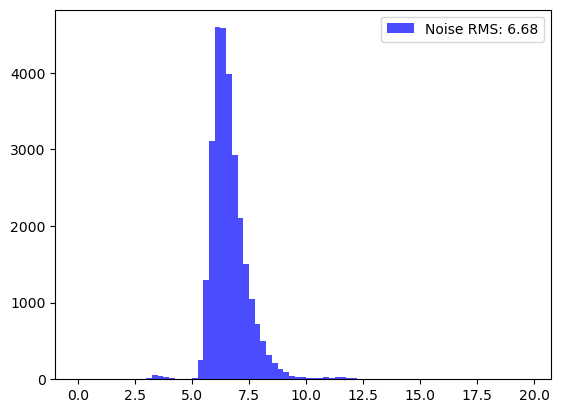

In [64]:
rmsRaw = np.sqrt(np.mean(noise.flatten()**2))
noisebins     = np.arange(0, 20, 0.25);

plt.hist(noise.flatten(), bins=noisebins, color='blue',  label = 'Noise RMS: {:.2f}'.format(rmsRaw), alpha=0.7);
plt.legend()
plt.show()
